# Deep Meme Caption Generator
<img src="meme_characters/futurama-fry/futurama-fry.jpg" align="left">
<img src="meme_characters/philosoraptor/philosoraptor.jpg" align="right">
<img src="meme_characters/y-u-no/y-u-no.jpg" align="center">

In [1]:
%matplotlib inline
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import configuration as config

from utils.vocabulary import Vocabulary
from utils.caption_generator import CaptionGenerator
from utils.inception_v3 import preprocess_input
from model import MemeModel
from keras.models import load_model
from keras.preprocessing import image
from utils.inception_v3 import preprocess_input
from ipywidgets import interact

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


## Initial arguments

In [2]:
checkpoint_path = 'model5.16/train/'
vocab_file = 'batches/word_count.txt'
dataset_dir = 'batches/part-0-to-11960/'
model_file = 'small-conv/model.h5'

In [3]:
count = 0
ncount = 0
with open(vocab_file, 'r') as f:
    for line in f:
        splitted = line.split()
        freq = int(splitted[1])
        ncount += 1
        count = count + 1 if freq > 50 else count
print(ncount, count)

7412 1194


## Wrapper functions to generate captions

In [4]:
def build_model(dataset_dir, image_format='jpeg'):
    model = MemeModel('inference',
                      vocab_file,
                      model_file=model_file,
                      dataset_dir=dataset_dir)
    model.build(image_format)
    return model

def feed_image(sess, encoded_image):
    initial_state = sess.run(fetches="lstm/initial_state:0",
                             feed_dict={"image_feed:0": encoded_image})
    return initial_state

def inference_step(sess, input_feed, state_feed):
    softmax_output, state_output = sess.run(
        fetches=["softmax:0", "lstm/state:0"],
        feed_dict={
            "input_feed:0": input_feed,
            "lstm/state_feed:0": state_feed,
        })
    return softmax_output, state_output, None

## Build and restore model functions

In [5]:
# Creates a function that restores a model from checkpoint
def create_restore_fn(checkpoint_path, saver):
    if tf.gfile.IsDirectory(checkpoint_path):
        checkpoint_path = tf.train.latest_checkpoint(checkpoint_path)
        if not checkpoint_path:
            raise ValueError("No checkpoint file found in: %s" % checkpoint_path)

    def _restore_fn(sess):
        tf.logging.info("Loading model from checkpoint: %s", checkpoint_path)
        saver.restore(sess, checkpoint_path)
        tf.logging.info("Successfully loaded checkpoint: %s",
                        os.path.basename(checkpoint_path))
        
    return _restore_fn

# Builds the inference graph from a configuration object.
def build_graph_from_config(data_dir, checkpoint_path, image_format='jpeg'):
    tf.logging.info("Building model.")
    model = build_model(data_dir, image_format)
    saver = tf.train.Saver(tf.global_variables())
    return create_restore_fn(checkpoint_path, saver), model

## Build model and inference graph

In [6]:
tf.reset_default_graph()
#g = tf.Graph()
#with g.as_default():
restore_fn, mememodel = build_graph_from_config(dataset_dir,
                                                checkpoint_path,
                                                image_format='jpeg')
#g.finalize()

INFO:tensorflow:Building model.
Initializing the model's parameters...
Mapping image embeddings...
(1, 128)
Building the LSTM model...
(1, 100)
Setting up the global step tensor...


In [7]:
# Create the vocabulary.
vocab = Vocabulary(vocab_file)

INFO:tensorflow:Initializing vocabulary from file: batches/word_count.txt
INFO:tensorflow:Created vocabulary with 7412 words


## Run caption generation over `input_files`

In [8]:
#mememodel.model.outputs = [mememodel.model.layers[-1].output]
#mememodel.model.layers[-1].outbound_nodes = [
mememodel.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 148, 148, 32)      896       
_________________________________________________________________
conv2 (Conv2D)               (None, 146, 146, 16)      4624      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 73, 73, 16)        0         
_________________________________________________________________
droput1 (Dropout)            (None, 73, 73, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 85264)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               10913920  
__________

In [9]:
sess = tf.InteractiveSession()
restore_fn(sess)

INFO:tensorflow:Loading model from checkpoint: model5.16/train/model.ckpt-2000000
INFO:tensorflow:Restoring parameters from model5.16/train/model.ckpt-2000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-2000000


Prepare the caption generator. Here we are implicitly using the default beam search parameters.
See [`caption_generator.py`](utils/caption_generator.py) for a description of the
available beam search parameters.

In [10]:
generator = CaptionGenerator(feed_image, 
                             inference_step, 
                             vocab,
                             max_caption_length=8)

## CAPTION IMAGES!!

In [11]:
# Meme paths to be captioned
input_files = ['meme_characters/american-pride-eagle/american-pride-eagle.jpg']

input_files += list(map(lambda f: os.path.join('test', f), os.listdir('test')))

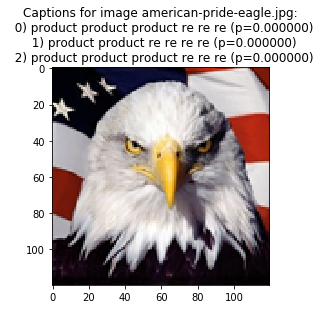

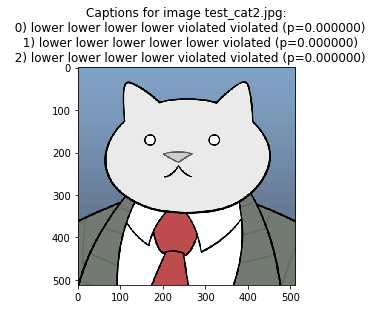

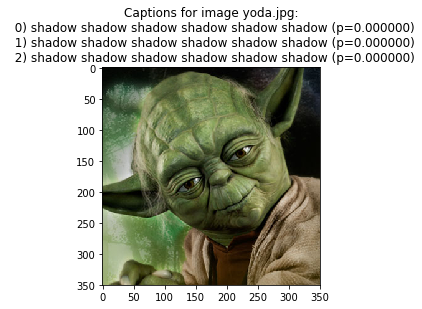

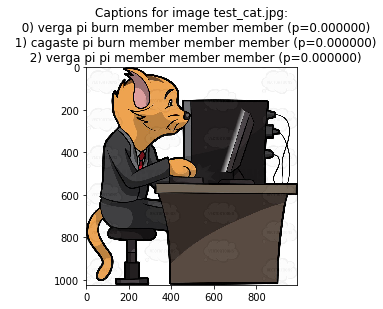

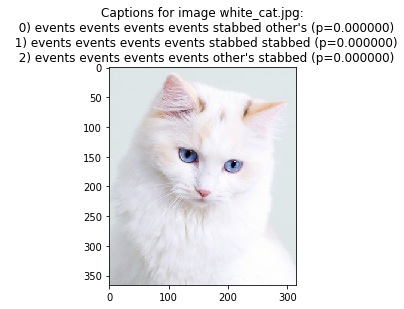

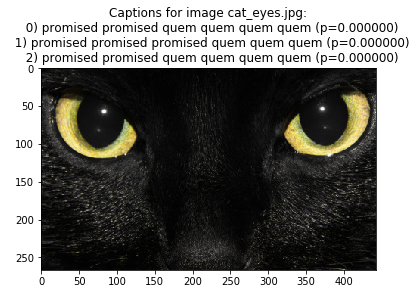

In [12]:
for filename in input_files:
    if os.path.exists(filename):        
        # Caption image
        img = image.load_img(filename, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = mememodel.model.predict(x)
        captions = generator.beam_search(sess, preds)
        ccs = 'Captions for image %s:' % os.path.basename(filename)
        for i, caption in enumerate(captions):
            # Ignore begin and end words.
            sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
            sentence = " ".join(sentence)
            ccs += '\n{}'.format('  %d) %s (p=%f)' % (i, sentence, math.exp(caption.logprob)))
            
        # Display image
        im = mpimg.imread(filename)
        plt.title(ccs)
        plt.imshow(im)
        plt.figure()


In [13]:
sample_dir = 'sample/'
sample_imgs = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir)]

@interact(original_image=sample_imgs)
def test_sample(original_image):
    img = image.load_img(original_image, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    preds = mememodel.model.predict(x)
    captions = generator.beam_search(sess, preds)
    ccs = 'Captions for image %s:' % os.path.basename(original_image)
    for i, caption in enumerate(captions):
        sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
        sentence = " ".join(sentence)
        ccs += '\n{}'.format('  %d) %s (p=%f)' % (i, sentence, math.exp(caption.logprob)))
            
    # Display image
    im = mpimg.imread(original_image)
    plt.title(ccs)
    plt.imshow(im)
    plt.figure()

interactive(children=(Dropdown(description='original_image', options=('sample/girl2.jpg', 'sample/crying-peter-parker.jpg', 'sample/night.jpg', 'sample/guy-bathroom.jpg', 'sample/girl1.jpg', 'sample/es-bakans.jpg', 'sample/african-kids-dancing.jpg', 'sample/girl3.jpg', 'sample/bender.jpg', 'sample/fat-black.jpg', 'sample/map.jpg', 'sample/dont-you-squidward.jpg', 'sample/anti-joke-chicken.jpg'), value='sample/girl2.jpg'), Output()), _dom_classes=('widget-interact',))

In [14]:
import pandas as pd

datum = pd.read_csv('batches/part-0-to-11960/memes.csv')
characters = set(datum['IMG_PATH'])

In [15]:
len(characters), characters

(3339,
 {'batches/img/very-optimistic-smile.jpg',
  'batches/img/i-double-dare-you.jpg',
  'batches/img/insanity-blonde.jpg',
  'batches/img/shirokov.jpg',
  'batches/img/and-im-just-sitting-here-masterbating.jpg',
  'batches/img/animeshnik-otaku-narutofan.jpg',
  'batches/img/desk-flip-rage-guy.jpg',
  'batches/img/bad-joke-jerry.jpg',
  'batches/img/disapproving-batman.jpg',
  'batches/img/condescending-director.jpg',
  'batches/img/retard-horse.jpg',
  'batches/img/scruffy.jpg',
  'batches/img/ryans-penis.jpg',
  'batches/img/finnishproblems.jpg',
  'batches/img/coreagues-geologist.jpg',
  'batches/img/schrute-facts.jpg',
  'batches/img/nerd89.jpg',
  'batches/img/we-will-rebuild.jpg',
  'batches/img/duizhang-problems.jpg',
  'batches/img/libertardian-advice.jpg',
  'batches/img/kollegah-der-boss.jpg',
  'batches/img/xdan.jpg',
  'batches/img/j-walter-weatherman.jpg',
  'batches/img/abouthomestuck.jpg',
  'batches/img/super-cool-ski-instructor.jpg',
  'batches/img/smithies.jpg',
  '